In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

def plot_combined_model_results(json_filepath, model_name, output_path):
    """
    Loads model evaluation results from a JSON file and plots all conditions
    on a single figure. It specifically renders 'rule_only' and 
    'rule_only_query_desc' as horizontal dashed lines across all shot counts.
    """
    # --- 1. Load and Validate Data ---
    try:
        with open(json_filepath, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: JSON file not found at {json_filepath}")
        return
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {json_filepath}")
        return

    if model_name not in data:
        print(f"Error: Model '{model_name}' not found in the JSON data.")
        return

    print(f"Processing data for model '{model_name}'...")

    # --- 2. Consolidate Data for Plotting ---
    all_plot_data = []
    datasets_for_model = data[model_name]
    conditions_to_plot = [
        'w_img', 'w_blank_img_all', 'w_blank_query_img', 'w_blank_demo_img', 
        'demo_desc_query_img', 'demo_desc_query_desc', 'demo_img_desc_query_img',
        'demo_img_desc_query_img_desc', 'demo_img_desc_query_img_desc_after_labels',
        'rule_only_query_desc', 'rule_only', 'rule_demo'
    ]

    for dataset, shots_data in datasets_for_model.items():
        sorted_shots = sorted([int(s) for s in shots_data.keys()])
        for shot_val in sorted_shots[:5]:
            shot_str = str(shot_val)
            for condition_name in conditions_to_plot:
                score = shots_data[shot_str].get(condition_name)
                if score is not None:
                    all_plot_data.append({
                        "dataset": dataset,
                        "shots": shot_val,
                        "score": score,
                        "condition": condition_name
                    })

    if not all_plot_data:
        print(f"No data found for any condition for model '{model_name}'. Cannot generate plot.")
        return
        
    df_all = pd.DataFrame(all_plot_data)

    # --- 3. Data Manipulation for Horizontal Lines ---
    horizontal_line_conditions = ['rule_only', 'rule_only_query_desc']
    all_shots_values = sorted(df_all['shots'].unique())
    expanded_data_list = []
    original_horizontal_data = df_all[df_all['condition'].isin(horizontal_line_conditions)]

    for condition_name in horizontal_line_conditions:
        condition_df = original_horizontal_data[original_horizontal_data['condition'] == condition_name]
        if not condition_df.empty:
            constant_score = condition_df['score'].iloc[0]
            dataset_name = condition_df['dataset'].iloc[0]
            print(f"Extrapolating '{condition_name}' with score {constant_score} across all shots.")
            for shot_val in all_shots_values:
                expanded_data_list.append({
                    'dataset': dataset_name,
                    'shots': shot_val,
                    'score': constant_score,
                    'condition': condition_name
                })

    df_all = df_all[~df_all['condition'].isin(horizontal_line_conditions)]
    if expanded_data_list:
        df_expanded = pd.DataFrame(expanded_data_list)
        df_all = pd.concat([df_all, df_expanded], ignore_index=True)

    # --- 4. Styling: colorblind-friendly, high-contrast palette ---
    sns.set_style("whitegrid")

    # Okabe–Ito (colorblind-safe) base palette
    okabe_ito = [
        "#0072B2",  # blue
        "#D55E00",  # vermillion
        "#009E73",  # green
        "#CC79A7",  # magenta
        "#F0E442",  # yellow
        "#56B4E9",  # sky blue
        "#E69F00",  # orange
        "#000000",  # black
    ]

    # Get unique conditions to make a deterministic color map
    unique_conditions = list(df_all['condition'].unique())

    # If more conditions than base colors, extend palette by repeating with slight lightness variations
    def extend_palette(base_colors, needed):
        colors = []
        cycles = (needed + len(base_colors) - 1) // len(base_colors)
        for c in range(cycles):
            # slightly adjust alpha or luminance via matplotlib to create distinct variants
            for hex_col in base_colors:
                colors.append(hex_col)
        return colors[:needed]

    color_list = extend_palette(okabe_ito, len(unique_conditions))
    color_map = {cond: color_list[i] for i, cond in enumerate(unique_conditions)}

    # Custom dash styles
    dashes_map = {cond: "" for cond in unique_conditions}
    dashes_map['rule_only'] = (4, 2)
    dashes_map['rule_only_query_desc'] = (2, 2)

    plt.figure(figsize=(20, 5.5))
    ax = sns.lineplot(
        data=df_all,
        x="shots",
        y="score",
        hue="condition",
        style="condition",
        dashes=dashes_map,
        markers=True,
        linewidth=3,        # slightly thicker for readability
        markersize=9,
        palette=color_map   # apply our deterministic color map
    )

    # --- 5. Customize and Display the Plot ---
    plt.title(f'Model: {model_name} - Performance Comparison on Open-Ended Mini-ImageNet', fontsize=16)
    plt.xlabel('Number of Shots', fontsize=12)
    plt.ylabel('Score (%)', fontsize=12)
    plt.ylim(0, 100)
    plt.xticks(all_shots_values)
    plt.grid(True, linewidth=0.6)

    # Move legend outside on the right
    legend = ax.legend(
        title="Condition",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0.0,
        fontsize='large',
        title_fontsize='x-large'
    )

    # Reserve space on the right so legend isn't clipped
    plt.tight_layout(rect=[0, 0, 0.8, 1])

    # Save the figure.
    plt.savefig(output_path, bbox_inches='tight')
    print(f"Successfully generated and saved combined plot to: {os.path.abspath(output_path)}")

    plt.show()
    plt.close()

# Qwen2.5-vl


Starting combined plot generation for model: qwen2.5-vl-3b
Processing data for model 'qwen2.5-vl-3b'...
Extrapolating 'rule_only' with score 77.0 across all shots.
Extrapolating 'rule_only_query_desc' with score 94.0 across all shots.
Successfully generated and saved combined plot to: /home/eml/yiran.huang/VL-ICL/results/qwen2.5-vl-3b/plots/combined_performance_plot_with_rules.png


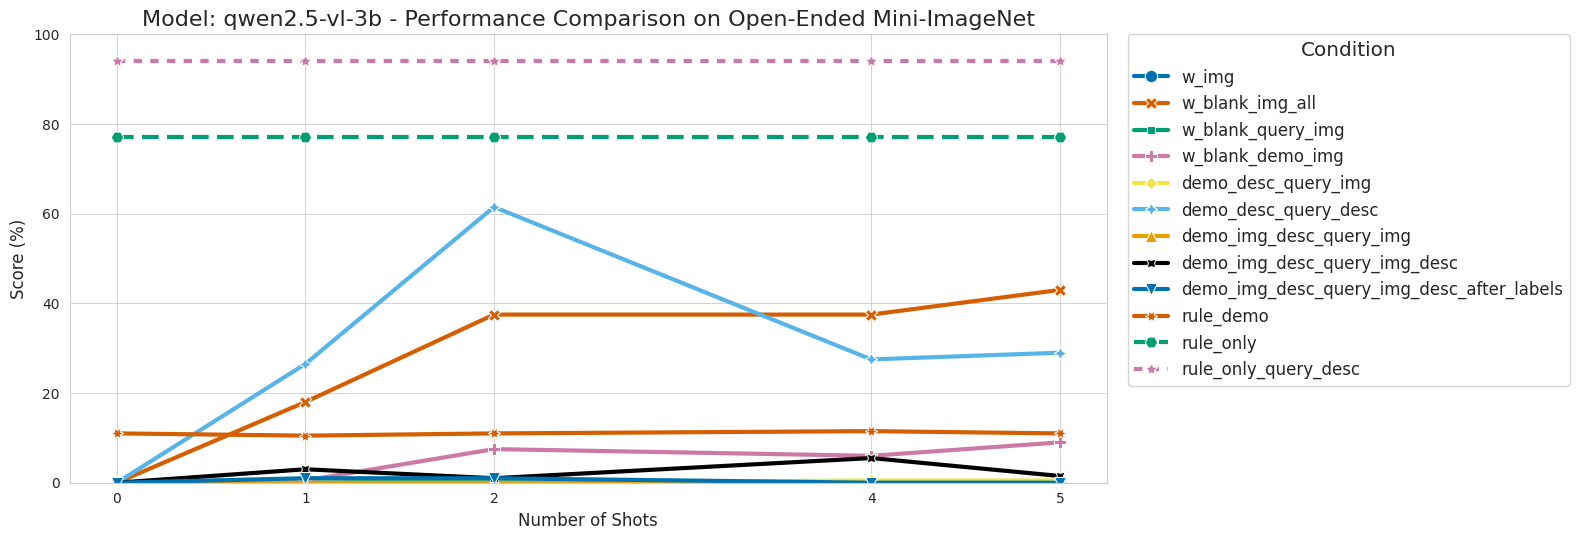


Plotting complete.


In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# --- Configuration ---
# Define the model and the path to the results file.
target_model = "qwen2.5-vl-3b"
json_file_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/compiled_evaluation_results_{target_model}.json"
# Define the output directory for the combined plot.
output_plot_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/plots/combined_performance_plot_with_rules.png"
# Ensure the output directory exists.
output_plots_directory = os.path.dirname(output_plot_path)
if not os.path.exists(output_plots_directory):
    os.makedirs(output_plots_directory)

# --- Run the function ---
print(f"Starting combined plot generation for model: {target_model}")
plot_combined_model_results(json_file_path, target_model, output_plot_path)
print("\nPlotting complete.")

In [30]:
import json
import os
import pandas as pd

def display_comparison_table(input_filename="data.json",model_name="qwen2.5-vl-3b",dataset_name="open_mi"):
    """
    Reads model evaluation data from a JSON file, calculates performance differences,
    and prints a formatted table to the console using the pandas library.

    Args:
        input_filename (str): The path to the input JSON file.
    """
    # --- 1. Load Data from File ---
    print(f"Attempting to read data from '{input_filename}'...")
    try:
        with open(input_filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: Input file not found at '{os.path.abspath(input_filename)}'.")
        print("Please ensure the JSON file exists in the correct directory.")
        return
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from '{input_filename}'.")
        print(f"Please check the file for syntax errors. Details: {e}")
        return
    
    print("Successfully loaded and parsed JSON data.\n")

    # --- 2. Prepare Data and Extract Key Values ---
    
    if model_name not in data or dataset_name not in data[model_name]:
        print(f"Error: Required data for '{model_name}' -> '{dataset_name}' not found in the JSON file.")
        return
        
    all_shot_data = data[model_name][dataset_name]
    shots = sorted([int(s) for s in all_shot_data.keys()])

    # Extract special values (for "one vs. all" comparisons) from the 1-shot data
    one_shot_scores = all_shot_data.get('1', {})
    rule_only_val = one_shot_scores.get('rule_only')
    rule_only_query_desc_val = one_shot_scores.get('rule_only_query_desc')

    # --- 3. Define Row Calculations ---
    # This structure remains the same, defining the logic for each row.
    row_definitions = [
        {
            "label": "w_img (Baseline)",
            "calculation": lambda scores, shot: scores.get('w_img')
        },
        {
            "label": "Demo mage usage: w_img - w_blank_demo_img - the higher the better",
            "calculation": lambda scores, shot:  f"{(scores.get('w_blank_demo_img')):.1f}( {(scores.get('w_img')- scores.get('w_blank_demo_img'))})" if 'w_img' in scores and 'w_blank_demo_img' in scores else 'N/A'
        },
        {
            "label": "Query image usage: w_img - w_blank_query_img - the higher the better",
            "calculation": lambda scores, shot:  f"{scores.get('w_blank_query_img'):.1f}( {(scores.get('w_img')- scores.get('w_blank_query_img'))})" if 'w_img' in scores and 'w_blank_query_img' in scores else 'N/A'
        },
        {
            "label": "All image usage: w_img - w_blank_img_all - the higher the better",
            "calculation": lambda scores, shot:  f"{scores.get('w_blank_img_all'):.1f}( {(scores.get('w_img')- scores.get('w_blank_img_all'))})" if 'w_img' in scores and 'w_blank_img_all' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_desc_query_img - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_desc_query_img'):.1f}( {(scores.get('demo_desc_query_img') - scores.get('w_img'))})" if 'demo_desc_query_img' in scores and 'w_img' in scores else 'N/A'
        },
         {
            "label": "Text reasoning: demo_desc_query_desc - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_desc_query_desc'):.1f}( {(scores.get('demo_desc_query_desc') - scores.get('w_img'))})" if 'demo_desc_query_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_img_desc_query_img - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_img_desc_query_img'):.1f}( {(scores.get('demo_img_desc_query_img') - scores.get('w_img'))})" if 'demo_img_desc_query_img' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_img_desc_query_img_desc - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_img_desc_query_img_desc'):.1f}( {(scores.get('demo_img_desc_query_img_desc') - scores.get('w_img'))})" if 'demo_img_desc_query_img_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: rule_only_query_desc - w_img",
            "calculation": lambda scores, shot:  f"{rule_only_query_desc_val:.1f}( {(rule_only_query_desc_val - scores.get('w_img'))})" if rule_only_query_desc_val is not None and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Vision Gap: demo_desc_query_desc - w_img",
            "calculation": lambda scores, shot: f"{scores.get('demo_desc_query_desc') - scores.get('w_img'):.1f}( {(scores.get('demo_desc_query_desc') - scores.get('w_img'))})" if 'demo_desc_query_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Induction gap: rule_only  - w_img",
            "calculation": lambda scores, shot: f"{rule_only_val:.1f}( {(rule_only_val- scores.get('w_img'))})" if rule_only_val is not None and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Execution gap: 100 - rule_only_query_desc",
            "calculation": lambda scores, shot: f"{100 - rule_only_query_desc_val:.1f}( {(100 - rule_only_query_desc_val)})" if rule_only_query_desc_val is not None else 'N/A'
        }
    ]

    # --- 4. Process Data and Format for DataFrame ---
    table_data = []
    index_labels = []
    for definition in row_definitions:
        index_labels.append(definition["label"])
        row_values = []
        for shot in shots:
            shot_scores = all_shot_data.get(str(shot), {})
            value = definition["calculation"](shot_scores, shot)
            
            # Format the value into a string for display purposes
            if isinstance(value, (int, float)):
                # For difference rows, add a '+' for positive values
                if " - " in definition["label"]:
                    if value > 0:
                        formatted_value = f"+{value:.1f}"
                    else:
                        formatted_value = f"{value:.1f}"
                # For baseline rows, just format the number
                else:
                    formatted_value = f"{value:.1f}"
            else:
                # Handle non-numeric values like 'N/A'
                formatted_value = str(value)
            
            row_values.append(formatted_value)
        table_data.append(row_values)

    # --- 5. Create and Print Pandas DataFrame ---
    column_labels = [f"{s}-Shot" for s in shots]
    
    # Create the DataFrame
    df = pd.DataFrame(table_data, index=index_labels, columns=column_labels)
    
    # Set display options to show all columns without truncation
    pd.set_option('display.width', 5000)
    pd.set_option('display.max_columns', 20)

    # Print a title and the DataFrame
    print(f"--- Performance Analysis: {model_name} | {dataset_name} ---")
    print(df)
    print("-" * (len(df.to_string().split('\n')[0]))) # Print a separator line



display_comparison_table(input_filename=json_file_path, model_name=target_model, dataset_name='open_mi')

Attempting to read data from '/home/eml/yiran.huang/VL-ICL/results/qwen2.5-vl-3b/compiled_evaluation_results_qwen2.5-vl-3b.json'...
Successfully loaded and parsed JSON data.

--- Performance Analysis: qwen2.5-vl-3b | open_mi ---
                                                         0-Shot        1-Shot        2-Shot        4-Shot        5-Shot
w_img (Baseline)                                            0.0           0.0           0.0           0.0           0.0
Demo mage usage: w_img - w_blank_demo_img - the...    0.0( 0.0)    0.5( -0.5)    7.5( -7.5)    6.0( -6.0)    9.0( -9.0)
Query image usage: w_img - w_blank_query_img - ...    0.0( 0.0)     0.0( 0.0)    0.5( -0.5)     0.0( 0.0)     0.0( 0.0)
All image usage: w_img - w_blank_img_all - the ...    0.0( 0.0)  18.0( -18.0)  37.5( -37.5)  37.5( -37.5)  43.0( -43.0)
Text reasoning: demo_desc_query_img - w_img           0.0( 0.0)     0.0( 0.0)     0.0( 0.0)     0.5( 0.5)     0.5( 0.5)
Text reasoning: demo_desc_query_desc - w_img       

# Qwen2.5vl-7b

Starting combined plot generation for model: qwen2.5-vl-7b
Processing data for model 'qwen2.5-vl-7b'...
Extrapolating 'rule_only' with score 96.0 across all shots.
Extrapolating 'rule_only_query_desc' with score 99.5 across all shots.
Successfully generated and saved combined plot to: /home/eml/yiran.huang/VL-ICL/results/qwen2.5-vl-7b/plots/combined_performance_plot_with_rules.png


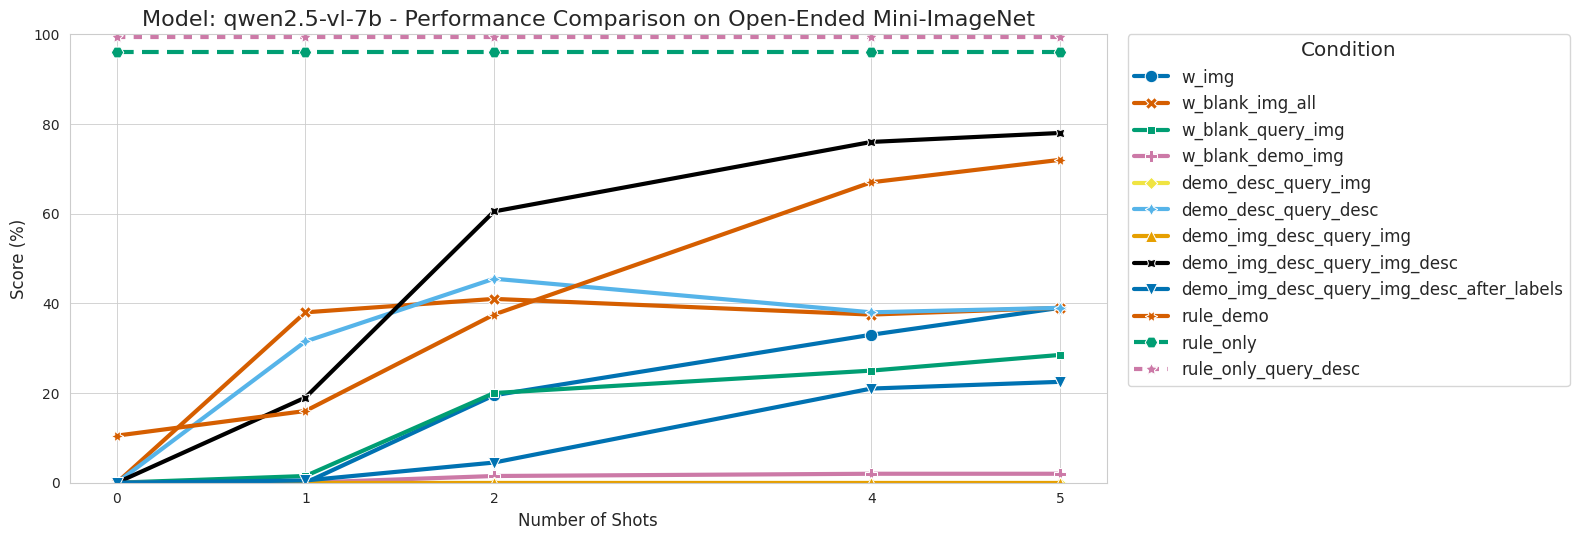


Plotting complete.


In [32]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# --- Configuration ---
# Define the model and the path to the results file.
target_model = "qwen2.5-vl-7b"
json_file_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/compiled_evaluation_results_{target_model}.json"
# Define the output directory for the combined plot.
output_plot_path = f"/home/eml/yiran.huang/VL-ICL/results/{target_model}/plots/combined_performance_plot_with_rules.png"
# Ensure the output directory exists.
output_plots_directory = os.path.dirname(output_plot_path)
if not os.path.exists(output_plots_directory):
    os.makedirs(output_plots_directory)

# --- Run the function ---
print(f"Starting combined plot generation for model: {target_model}")
plot_combined_model_results(json_file_path, target_model, output_plot_path)
print("\nPlotting complete.")

In [33]:
import json
import os
import pandas as pd

def display_comparison_table(input_filename="data.json",model_name="qwen2.5-vl-3b",dataset_name="open_mi"):
    """
    Reads model evaluation data from a JSON file, calculates performance differences,
    and prints a formatted table to the console using the pandas library.

    Args:
        input_filename (str): The path to the input JSON file.
    """
    # --- 1. Load Data from File ---
    print(f"Attempting to read data from '{input_filename}'...")
    try:
        with open(input_filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: Input file not found at '{os.path.abspath(input_filename)}'.")
        print("Please ensure the JSON file exists in the correct directory.")
        return
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from '{input_filename}'.")
        print(f"Please check the file for syntax errors. Details: {e}")
        return
    
    print("Successfully loaded and parsed JSON data.\n")

    # --- 2. Prepare Data and Extract Key Values ---
    
    if model_name not in data or dataset_name not in data[model_name]:
        print(f"Error: Required data for '{model_name}' -> '{dataset_name}' not found in the JSON file.")
        return
        
    all_shot_data = data[model_name][dataset_name]
    shots = sorted([int(s) for s in all_shot_data.keys()])

    # Extract special values (for "one vs. all" comparisons) from the 1-shot data
    one_shot_scores = all_shot_data.get('1', {})
    rule_only_val = one_shot_scores.get('rule_only')
    rule_only_query_desc_val = one_shot_scores.get('rule_only_query_desc')

    # --- 3. Define Row Calculations ---
    # This structure remains the same, defining the logic for each row.
    row_definitions = [
        {
            "label": "w_img (Baseline)",
            "calculation": lambda scores, shot: scores.get('w_img')
        },
        {
            "label": "Demo mage usage: w_img - w_blank_demo_img - the higher the better",
            "calculation": lambda scores, shot:  f"{(scores.get('w_blank_demo_img')):.1f}( {(scores.get('w_img')- scores.get('w_blank_demo_img'))})" if 'w_img' in scores and 'w_blank_demo_img' in scores else 'N/A'
        },
        {
            "label": "Query image usage: w_img - w_blank_query_img - the higher the better",
            "calculation": lambda scores, shot:  f"{scores.get('w_blank_query_img'):.1f}( {(scores.get('w_img')- scores.get('w_blank_query_img'))})" if 'w_img' in scores and 'w_blank_query_img' in scores else 'N/A'
        },
        {
            "label": "All image usage: w_img - w_blank_img_all - the higher the better",
            "calculation": lambda scores, shot:  f"{scores.get('w_blank_img_all'):.1f}( {(scores.get('w_img')- scores.get('w_blank_img_all'))})" if 'w_img' in scores and 'w_blank_img_all' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_desc_query_img - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_desc_query_img'):.1f}( {(scores.get('demo_desc_query_img') - scores.get('w_img'))})" if 'demo_desc_query_img' in scores and 'w_img' in scores else 'N/A'
        },
         {
            "label": "Text reasoning: demo_desc_query_desc - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_desc_query_desc'):.1f}( {(scores.get('demo_desc_query_desc') - scores.get('w_img'))})" if 'demo_desc_query_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_img_desc_query_img - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_img_desc_query_img'):.1f}( {(scores.get('demo_img_desc_query_img') - scores.get('w_img'))})" if 'demo_img_desc_query_img' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: demo_img_desc_query_img_desc - w_img",
            "calculation": lambda scores, shot:  f"{scores.get('demo_img_desc_query_img_desc'):.1f}( {(scores.get('demo_img_desc_query_img_desc') - scores.get('w_img'))})" if 'demo_img_desc_query_img_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Text reasoning: rule_only_query_desc - w_img",
            "calculation": lambda scores, shot:  f"{rule_only_query_desc_val:.1f}( {(rule_only_query_desc_val - scores.get('w_img'))})" if rule_only_query_desc_val is not None and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Vision Gap: demo_desc_query_desc - w_img",
            "calculation": lambda scores, shot: f"{scores.get('demo_desc_query_desc') - scores.get('w_img'):.1f}( {(scores.get('demo_desc_query_desc') - scores.get('w_img'))})" if 'demo_desc_query_desc' in scores and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Induction gap: rule_only  - w_img",
            "calculation": lambda scores, shot: f"{rule_only_val:.1f}( {(rule_only_val- scores.get('w_img'))})" if rule_only_val is not None and 'w_img' in scores else 'N/A'
        },
        {
            "label": "Execution gap: 100 - rule_only_query_desc",
            "calculation": lambda scores, shot: f"{100 - rule_only_query_desc_val:.1f}( {(100 - rule_only_query_desc_val)})" if rule_only_query_desc_val is not None else 'N/A'
        }
    ]

    # --- 4. Process Data and Format for DataFrame ---
    table_data = []
    index_labels = []
    for definition in row_definitions:
        index_labels.append(definition["label"])
        row_values = []
        for shot in shots:
            shot_scores = all_shot_data.get(str(shot), {})
            value = definition["calculation"](shot_scores, shot)
            
            # Format the value into a string for display purposes
            if isinstance(value, (int, float)):
                # For difference rows, add a '+' for positive values
                if " - " in definition["label"]:
                    if value > 0:
                        formatted_value = f"+{value:.1f}"
                    else:
                        formatted_value = f"{value:.1f}"
                # For baseline rows, just format the number
                else:
                    formatted_value = f"{value:.1f}"
            else:
                # Handle non-numeric values like 'N/A'
                formatted_value = str(value)
            
            row_values.append(formatted_value)
        table_data.append(row_values)

    # --- 5. Create and Print Pandas DataFrame ---
    column_labels = [f"{s}-Shot" for s in shots]
    
    # Create the DataFrame
    df = pd.DataFrame(table_data, index=index_labels, columns=column_labels)
    
    # Set display options to show all columns without truncation
    pd.set_option('display.width', 5000)
    pd.set_option('display.max_columns', 20)

    # Print a title and the DataFrame
    print(f"--- Performance Analysis: {model_name} | {dataset_name} ---")
    print(df)
    print("-" * (len(df.to_string().split('\n')[0]))) # Print a separator line



display_comparison_table(input_filename=json_file_path, model_name=target_model, dataset_name='open_mi')

Attempting to read data from '/home/eml/yiran.huang/VL-ICL/results/qwen2.5-vl-7b/compiled_evaluation_results_qwen2.5-vl-7b.json'...
Successfully loaded and parsed JSON data.

--- Performance Analysis: qwen2.5-vl-7b | open_mi ---
                                                         0-Shot        1-Shot        2-Shot       4-Shot       5-Shot
w_img (Baseline)                                            0.0           0.0          19.5         33.0         39.0
Demo mage usage: w_img - w_blank_demo_img - the...    0.0( 0.0)     0.0( 0.0)    1.5( 18.0)   2.0( 31.0)   2.0( 37.0)
Query image usage: w_img - w_blank_query_img - ...    0.0( 0.0)    1.5( -1.5)   20.0( -0.5)   25.0( 8.0)  28.5( 10.5)
All image usage: w_img - w_blank_img_all - the ...    0.0( 0.0)  38.0( -38.0)  41.0( -21.5)  37.5( -4.5)   39.0( 0.0)
Text reasoning: demo_desc_query_img - w_img           0.0( 0.0)     0.0( 0.0)   0.0( -19.5)  0.0( -33.0)  0.0( -39.0)
Text reasoning: demo_desc_query_desc - w_img          0.0( 0.0)